In [1]:
import evoVAE.utils.seq_tools as st
from evoVAE.utils.datasets import MSA_Dataset
from evoVAE.models.seqVAETest import SeqVAETest
import evoVAE.utils.statistics as stats
import pandas as pd
import torch


pd.set_option("display.max_rows", None)

In [2]:
test_aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/encoded_weighted/gb1_extants_encoded_weighted_no_dupes.pkl")
#test_aln = pd.read_pickle("../data/gb1/gb1_ancestors_extants_encoded_weighted_no_dupes.pkl")
test_aln.head()

,id,sequence,encoding,weights
0,SPG1_STRSG/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066667
1,UniRef100_Q93EM8/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.250000
2,UniRef100_Q53975/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.250000
3,UniRef100_A0A509DAN6/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066667
4,UniRef100_A0A448DI38/1-351,MEKEKKMKYFLRKSAFGLASVSAAFLVGTTLDTTMTVSAEPAGIIA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.250000


In [17]:

train_dataset = MSA_Dataset(test_aln["encoding"], test_aln["weights"], test_aln["id"])
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=False
)

SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * 21


config={
            # Dataset info
            "alignment": "tets",
            "seq_theta": 0.2,  # reweighting
            "AA_count": 21,  # standard AA + gap
            "test_split": 0.2,
            "max_mutation": 4,  # how many mutations the model will test up to
            # ADAM
            "learning_rate": 1e-2,  # ADAM
            "weight_decay": 1e-4,  # ADAM
            # Hidden units
            "momentum": None,
            "dropout": None,
            # Training loop
            "epochs": 500,
            "batch_size": 128,
            "max_norm": 10,  # gradient clipping
            "patience": 3,
            # Model info - default settings
            "architecture": f"SeqVAE_0.25_ancestors_R",
            "latent_dims": 2,
            "hidden_dims": [256, 128, 64],
            # DMS data
            "dms_file": "../data/SPG1_STRSG_Wu_2016.pkl",
            "dms_metadata": "../data/DMS_substitutions.csv",
            "dms_id": "SPG1_STRSG_Wu_2016",
}



SEQ_LEN = 0
BATCH_ZERO = 0
SEQ_ZERO = 0
seq_len = train_dataset[BATCH_ZERO][SEQ_ZERO].shape[SEQ_LEN]
input_dims = seq_len * 21


gb1_good = "/Users/sebs_mac/git_repos/evoVAE/notebooks/gb1_ancestors_extants_encoded_weighted_no_dupes_model_state.pt"
model = SeqVAETest(input_dims, 3, hidden_dims=config["hidden_dims"], config=config)
model.load_state_dict(torch.load(gb1_good))
model.eval()

SeqVAETest(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=9408, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (z_mu_sampler): Linear(in_features=64, out_features=3, bias=True)
  (z_logvar_sampler): Linear(in_features=64, out_features=3, bias=True)
  (upscale_z): Linear(in_features=3, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (2): Linear(in_features=256, out_features=9408, bias=True)
  

In [18]:

num_samples = 10
ids = []
x_hats = []
model.eval()
for encoding, _, id in data_loader:

    # get into flat format to pass through the model
    encoding = encoding.float()
    encoding = torch.flatten(encoding, start_dim=1)

    # get encoding and replicate to allow multiple samples from latent space
    z_mu, z_logvar = model.encode(encoding)
    z_mu = z_mu.expand(num_samples, z_mu.shape[0], z_mu.shape[1])
    z_logvar = z_logvar.expand(num_samples, z_logvar.shape[0], z_logvar.shape[1])

    # pass each sample through the latent space and then average and decode
    z_samples = model.reparameterise(z_mu, z_logvar)
    mean_z = torch.mean(z_samples, dim=0)
    x_hat = model.decode(mean_z)

    ids.extend(id)
    x_hats.extend(x_hat.detach())

orig_shape = tuple(test_aln["encoding"].values[0].shape)
reconstructions = []
for x_hat in x_hats:

    # decode the Z sample and get it into a PPM shape
    x_hat = x_hat.unsqueeze(-1)
    # print(x_hat.shape)
    x_hat = x_hat.view(orig_shape)

    # Identify most likely residue at each column
    indices = x_hat.max(dim=-1).indices.tolist()
    recon = "".join([st.GAPPY_PROTEIN_ALPHABET[x] for x in indices])
    reconstructions.append(recon)


In [19]:
for i in range(0, 10):
    print(ids[i])
    print("actual", test_aln[test_aln["id"] == ids[i]]["sequence"].values[0])
    print("recon", reconstructions[i])
    print()
    

SPG1_STRSG/1-448
actual MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRNGGELTNLLGNSETTLALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGVSDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGDAPTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTTGEGSNPFFTAAALAVMAGAGALAVASKRKED
recon --KEKKVKYFLRKTAFGLASMSAAFLVCSGIVNADTVSAETATIRHKKGLKNKIKNVEETTKARKELKGTQNLAAAASADTALAQELDKAKAELNQAKVAAEELAKASQEAYDEINNLKDSSDQKDLIENAATVEKDSELEAKLVTQAEQANIAESNKAVNELLKNAEAAEQAISPEALEELKEQAKRELNENGVSEFYKKLINNNKTVDQVKELKEEILKAENQLNTYKLILNEKKLNLEATTEAADAKEAEQEFKQYANANGVDLEATYDAATKTEKATEEPAVKGKAKLKEAKTEYKLVLKGKTFEGEEGTKAVTEEKAEKEFKQYANDKGVDGVWTYDEETKTFVKTEKKPEVKPEADVKPEKPEAKPPVKP--EAKPEAKPDAKPEAKPAPNTKGNEAKKAAKKYAKKLPSTGEAANPFFAAVALAVMASAGLLTVALKRKK-

UniRef100_Q93EM8/1-351
actual MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE-

In [20]:
msa, _, _ = st.convert_msa_numpy_array(test_aln)
thing = stats.pair_wise_covariances_parallel(msa, 10)

Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)


In [21]:
recons_df = pd.DataFrame({"id": ids, "sequence": reconstructions})
recons_df.head()

recon_msa, _, _ = st.convert_msa_numpy_array(recons_df)
thing2 = stats.pair_wise_covariances_parallel(recon_msa, 10)

Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)


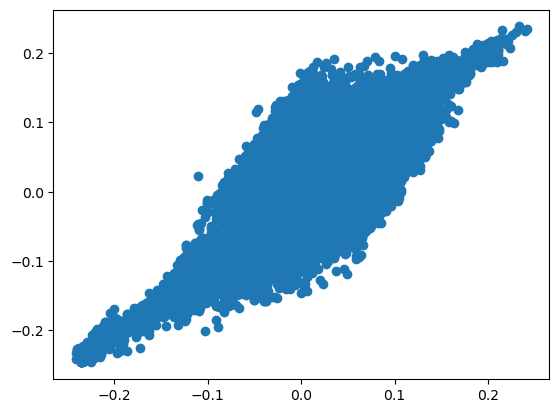

In [22]:
import matplotlib.pyplot as plt
plt.scatter(thing, thing2)
plt.show()

In [23]:
import numpy as np
correlation_coefficient = np.corrcoef(thing, thing2)
correlation_coefficient

array([[1.        , 0.65574675],
       [0.65574675, 1.        ]])

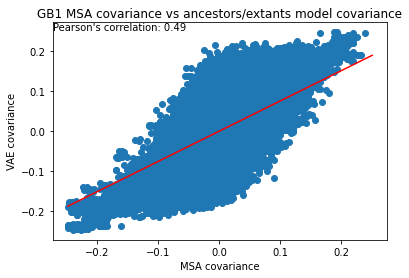

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gb1_corv_data = pd.read_csv("../data/gb1/covar/ancestors_extants_gb1_msa_cov.csv")
gb1_corv_data.head()


plt.scatter(gb1_corv_data['actual'], gb1_corv_data['prediction'])
plt.xlabel("MSA covariance")
plt.ylabel("VAE covariance")
slope, intercept = np.polyfit(gb1_corv_data['actual'], gb1_corv_data['prediction'], 1)
x = np.arange(min(gb1_corv_data['actual']),max(gb1_corv_data['actual']) + 0.1, 0.1)
regression_line = slope * x + intercept

# Calculate correlation coefficient
correlation_coefficient = np.corrcoef(gb1_corv_data['actual'], gb1_corv_data['prediction'])[0, 1]

# Display correlation value
plt.text(plt.xlim()[0], plt.ylim()[1], f'Pearson\'s correlation: {correlation_coefficient:.2f}', va='top')

# Plot regression line
plt.plot(x, regression_line, color='red')
plt.title("GB1 3000 random extants/ancestors")
plt.show()